In [57]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Pandas
import pandas as pd

### fitting
import statsmodels.api as sm

### PCA
from sklearn.decomposition import PCA, KernelPCA

### EMCEE
import emcee

### Model generation
import itertools as it

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable

# ### Yumi's RA/DEC ---> Magellanic Stream Coorindates
import MagellanicStream as ms

# ### Functions used in this code
import age_functions as afunc
import lmcgeometry as lgeo

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [109]:
###################
### Import Data ###
###################

# parsec
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3_3.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]


# lmc
lmc = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.r13-l33-58672.fits.gz')
cln = np.where((lmc['FE_H']>-9999.0)&(lmc['AK_TARG']>-100.0)&(lmc['LOGG']>=0.0)&
                (lmc['M_H_ERR']>-100.0)&(lmc['C_FE']>-100.0)&(lmc['N_FE']>-100.0))
lmc = lmc[cln]

# APOKASC
# kasc = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/APOKASC_cat_v6.6.1.fits.gz')

# Diane Feuillet
pdfout = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/LMC_DR16_all_PDF.fits.gz', 1)
_, lmc_ind, diane_ind = np.intersect1d(lmc['APOGEE_ID'],pdfout['OBJ'],return_indices=True)

In [ ]:
plt.figure(figsize=[12,10])
plt.scatter(parsec['logTe'],parsec['Ksmag'],c=parsec['logAge'],cmap='jet')
plt.colorbar()
plt.xlabel(r'logTe')
plt.ylabel(r'Ksmag')
plt.title(r'Color as logAge')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(parsec['logTe'],parsec['MH'],c=parsec['logAge'],cmap='jet')
plt.colorbar()
plt.xlabel(r'logTe')
plt.ylabel(r'MH')
plt.title(r'Color as logAge')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(parsec['logTe'],parsec['logg'],c=parsec['logAge'],cmap='jet')
plt.colorbar()
plt.xlabel(r'logTe')
plt.ylabel(r'logg')
plt.title(r'Color as logAge')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(parsec['Ksmag'],parsec['MH'],c=parsec['logAge'],cmap='jet')
plt.colorbar()
plt.xlabel(r'Ksmag')
plt.ylabel(r'MH')
plt.title(r'Color as logAge')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(parsec['Ksmag'],parsec['logg'],c=parsec['logAge'],cmap='jet')
plt.colorbar()
plt.xlabel(r'Ksmag')
plt.ylabel(r'logg')
plt.title(r'Color as logAge')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(parsec['MH'],parsec['logg'],c=parsec['logAge'],cmap='jet')
plt.colorbar()
plt.xlabel(r'MH')
plt.ylabel(r'logg')
plt.title(r'Color as logAge')
plt.show()

In [ ]:
arr_parsec = np.asarray([parsec['logTe'],parsec['Ksmag'],parsec['MH'],parsec['logg']]).T

print(r'PARSEC Covariance Matrix')
print(np.cov(arr_parsec.T))

### Determine Number of factors
pca = PCA(n_components=4).fit(arr_parsec)#_rescaled)
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()

y = np.cumsum(pca.explained_variance_ratio_)
xi = np.arange(1, len(pca.explained_variance_ratio_)+1, step=1)

plt.ylim(0.8,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 5, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.99, color='r', linestyle='-')
plt.text(0.5, 1.0, '99% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [123]:
######################
### MCMC Fucntions ###
######################

import numpy as np
from scipy.optimize import minimize
from scipy.stats import binned_statistic

### MLE Functions

def mad(dat):
    '''
    Calculate the median absolute deviation (MAD)
    
    Parameters:
    -----
        dat: array-like object containing data
    
    Returns:
    ----
        dev: MAD(dat)
    '''
    dev = np.median(np.absolute(dat - np.median(dat)))
    return dev

def agemodl(b,x):
    '''
    General model for ages upto 3rd order in logTe, Ksmag, MH, logg with simple interactions of linear terms. 
    
    Parameters:
    -----
        b: array-like object of model parameters with length 19
        x: array of independent variables (logTe, Ksmag, MH, logg)
    
    Returns:
    ----
        y: age
    '''

    y = (b[0]+
         b[1]*x[0]+b[2]*x[1]+b[3]*x[2]+
         b[4]*np.multiply(x[0],x[1])+b[5]*np.multiply(x[0],x[2])+
         b[6]*np.multiply(x[1],x[2])+
         b[7]*np.square(x[0])+b[8]*np.square(x[1])+b[9]*np.square(x[2])+
         b[10]*np.power(x[1],3)+b[11]*np.power(x[2],3))#+b[12]*np.power(x[2],3))
    
    return y

def agemodl_x0(b,x):
    '''
    Derivative of agemodl wrt x0 (q1)
    '''
    return b[1]+b[4]*x[1]+b[5]*x[2]+2*b[7]*x[0]#+3*b[10]*np.square(x[0])

def agemodl_x1(b,x):
    '''
    Derivative of agemodl wrt x1 (q2)
    '''
    return b[2]+b[4]*x[0]+b[6]*x[2]+2*b[8]*x[1]+3*b[10]*np.square(x[1])

def agemodl_x2(b,x):
    '''
    Derivative of agemodl wrt x2 (q3)
    '''
    return b[3]+b[5]*x[0]+b[6]*x[1]+2*b[9]*x[2]+3*b[11]*np.square(x[2])

# def agemodl_x3(b,x):
#     '''
#     Derivative of agemodl wrt x3 (logg)
#     '''
#     return 

def lnL(theta,x,y):
    '''
    Log likelihood for agemodl
    
    Parameters:
    -----
        theta: parameters to plug into linmodl (m,b)
        x: exog of line
        y: endog of line
        cv: covariance matrix of x data
    
    Returns:
    ----
        lnl: log likelihood 
    '''
  
    b = theta
#     cv = np.cov(x)
    modl = agemodl(b,x)
#     derivx0 = agemodl_x0(b,x)
#     derivx1 = agemodl_x1(b,x)
#     derivx2 = agemodl_x2(b,x)
#     derivx3 = agemodl_x3(b,x)
    inv_sig2 = 1. #np.reciprocal(derivx0**2*cv[0,0]+derivx1**2*cv[1,1]+derivx2**2*cv[2,2]+
#                              2*derivx0*derivx1*cv[0,1]+2*derivx0*derivx2*cv[0,2]+2*derivx1*derivx2*cv[1,2])
    lnl = -0.5 * np.sum(np.multiply(np.square((y - modl)),inv_sig2) - np.log(inv_sig2/(2*np.pi)))
    return lnl

### MCMC Specific

def lnPrior(theta):
    '''
    Using a flat prior to calculate the log prior
    
    Parameters:
    -----
    theta: model parameters
    
    '''
    b = theta
    if (-100. < b[0] < 100. and -50. < b[1] < 50. and -50. < b[2] < 50. and -50. < b[3] < 50. and 
        -50. < b[4] < 50. and -50. < b[5] < 50. and -50. < b[6] < 50. and -50. < b[7] < 50. 
        and -50. < b[8] < 50. and -0.5 < b[9] < 0.5 and -50. < b[10] < 50. and -0.5 < b[11] < 0.5):
        return 0.0
    return -np.inf

def lnProb(theta, x, y):
    '''
    Calculate the log probability
    
    Parameters:
    -----
    theta: model parameters
    x: x coordinate data
    y: y coordinate data
    y_err: y error
    
    '''
    
    lnP = lnPrior(theta)
    if not np.isfinite(lnP):
        return -np.inf
    return lnP + lnL(theta, x, y)

In [130]:
############
### MCMC ###
############

pca_arr_parsec = PCA(n_components=3).fit(arr_parsec).transform(arr_parsec)

### linear
q0 = pca_arr_parsec[:,0]
q1 = pca_arr_parsec[:,1]
q2 = pca_arr_parsec[:,2]

# guess = np.ones(12) #length of guess muct be the same as ndim
guess = [9.38631710e+00,4.57009017e-02,-5.98198867e-02,-2.99642242e+00,1.86921027e-02,-4.51165023e-02,
         1.10829968e-01,-5.93377185e-03,2.51457473e-02,7.98522275e-01,2.26643514e-02,4.00941011e-01]
niter = 1000
ndim, nwalkers = 12,500 
pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnProb, args=([q0,q1,q2], parsec['logAge']))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [1:09:31<00:00,  1.20it/s]   


In [131]:
# tau = sampler.get_autocorr_time()
# print(tau)

flat_samples = sampler.get_chain(discard=500, thin=10, flat=True)

beta 0: 9.50088 +/- 0.00201
beta 1: 0.01788 +/- 0.00074
beta 2: -0.03699 +/- 0.00265
beta 3: -1.37865 +/- 0.01235
beta 4: 0.00647 +/- 0.00065
beta 5: 0.00540 +/- 0.00356
beta 6: -0.00073 +/- 0.00628
beta 7: 0.00383 +/- 0.00020
beta 8: 0.00364 +/- 0.00157
beta 9: -0.99272 +/- 0.00503
beta 10: 0.00944 +/- 0.00171
beta 11: -1.75878 +/- 0.12265
[9.50087645e+00 1.78818331e-02 3.69872784e-02 1.37864903e+00
 6.46803456e-03 5.39918897e-03 7.27646427e-04 3.83357538e-03
 3.63950682e-03 9.92720065e-01 9.44364388e-03 1.75877960e+00]


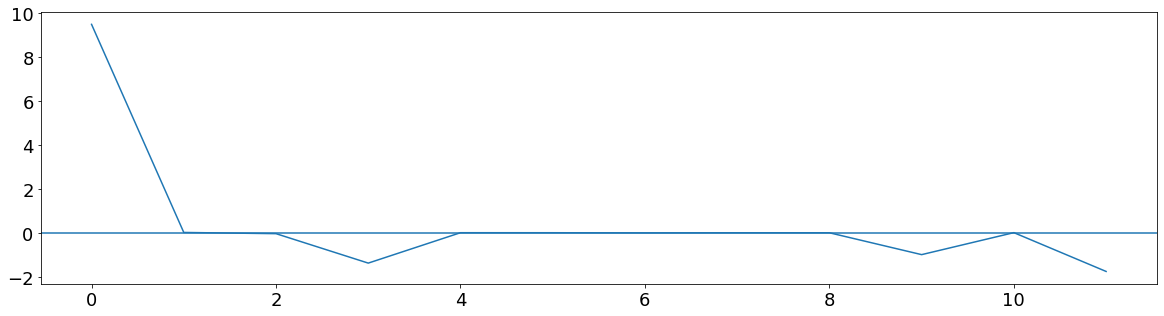

In [132]:
betas = []
betas_err = []
for i in range(len(guess)):
    betas.append(np.median(flat_samples[:,i]))
    betas_err.append(mad(flat_samples[:,i]))
    
betas
betas_err

for j in range(len(betas)):
    print(r'beta {}: {:.5f} +/- {:.5f}'.format(j,betas[j],betas_err[j]))
    
plt.figure(figsize=[20,5])
plt.plot(betas)
plt.axhline(0)
print(np.abs(betas))

In [133]:
np.asarray(betas) - np.array([9.38631710e+00,4.57009017e-02,-5.98198867e-02,-2.99642242e+00,1.86921027e-02,-4.51165023e-02,
         1.10829968e-01,-5.93377185e-03,2.51457473e-02,7.98522275e-01,2.26643514e-02,4.00941011e-01])

array([ 0.11455935, -0.02781907,  0.02283261,  1.61777339, -0.01222407,
        0.05051569, -0.11155761,  0.00976735, -0.02150624, -1.79124234,
       -0.01322071, -2.15972061])

In [134]:
def find_age(b,x0,x1,x2,x3):
    '''
    General model for ages upto 3rd order in logTe, Ksmag, MH, logg with simple interactions of linear terms. 
    
    Parameters:
    ----------
        b: array-like object of model parameters with length 19
        x0: temperature
        x1: magnitude
        x2: metallicity
        x3: logg
    
    Returns:
    -------
        y: age
    '''
    y = (b[0]+
         b[1]*x0+b[2]*x1+b[3]*x2+
         b[4]*np.multiply(x0,x1)+b[5]*np.multiply(x0,x2)+
         b[6]*np.multiply(x1,x2)+
         b[7]*np.square(x0)+b[8]*np.square(x1)+b[9]*np.square(x2)+
         b[10]*np.power(x1,3)+b[11]*np.power(x2,3))#+b[12]*np.power(x2,3))
    
    return y

def LMCdisk_cart(ra, dec):
    
    '''
    Calculate the position of stars in the LMC disk plane with 
    center at the LMC center in cartesian coordinates (x, y).
    This also calculates the distance to the individual stars.
    
    This follows van der Marel and Cioni 2001 
    
    Input
    - ra: right ascension of stars
    - dec: declination of stars
    
    Output
    - x_m: x coordinate
    - y_m: y coordinate
    - dis: distance to LMC star
    '''
    alph0 = np.radians(82.25) #right ascension of center of LMC
    delt0 = np.radians(-69.50) #declination of center of LMC
    pa = np.radians(149.23+90.00) #146.37 #position angle of line of nodes
    io = np.radians(25.86) #27.81 #inclination of LMC disk
    d0 = 49.90 #distance to center of LMC
    
    #convert to radians
    ra = np.radians(ra)
    dec = np.radians(dec)
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    
    cr = cd*np.cos(dec)*np.cos(ra-alph0)+sd*np.sin(dec)
    srcp = -np.cos(dec)*np.sin(ra-alph0)
    srsp = cd*np.sin(dec) - sd*np.cos(dec)*np.cos(ra-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cr - np.sin(io)*np.cos(pa)*srsp + np.sin(io)*np.sin(pa)*srcp)
    
    x_m = dis*srcp
    y_m = dis*(np.cos(io)*srsp + np.sin(io)*cr) - d0*np.sin(io)
    
    return x_m, y_m, dis

#calculate absolute mag
def absmag(magnitude,distance):
    '''
    - magnitude: apparent magnitude of star
    - distance: distance to star in kpc
    Calculate the absolute magnitude of star
    '''
    absm = []
    absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
    absm = np.squeeze(np.array(absm))
    return absm

def salaris(MH,aM):
    '''
    Calculate the Salaris correction to the overall metallicity
    '''
    return MH + np.log(0.638*(10**(aM))+0.362)
    
    
def add_noise(quant,quant_err,distribution='normal'):
    '''
    Add noise to data and return new values
    
    Parameters:
    ----------
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
        distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
    return: 
    ------
        1d array-like object of data with added noise
    
    '''
    if distribution == 'normal':
        return np.random.normal(quant,quant_err)
    if distribution == 'poisson':
        return quant + np.random.poisson(quant_err)
    if distribution == 'uniform':
        return np.random.uniform(-quant_err+quant,quant+quant_err)

In [135]:
age_dist = []

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    aM = r13['ALPHA_M'][i]
    aM_err = r13['ALPHA_M_ERR'][i]
#     feh = r13['FE_H'][i]
#     feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(750):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
            
        absK_new = absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        
#         x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+
#                                  add_noise(feh,feh_err)-add_noise(mh,mh_err))
#         x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+
#                                  add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
#         ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        aM_new = add_noise(aM,aM_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
#         new = np.array([lgteff_new,absK_new,salaris(mh_new,aM_new),lgg_new])
        noise_ages.append(find_age(betas,lgteff_new,absK_new,salaris(mh_new,aM_new),lgg_new))
        
#         new.append(np.array([lgteff_new,absK_new,salaris(mh_new,aM_new),lgg_new]))
        
#     zs = pca_transform.transform(np.asarray(np.squeeze(new)))

#     for l in range(len(zs)):
#         noise_ages.append(find_ages(new[l][0],new[l][1],new[l][2]))
    
    age_dist.append(noise_ages)

ages = [] 
ages_err = []
for k in tqdm_notebook(range(len(age_dist))):
    ages_err.append(mad(age_dist[k]))
    ages.append(np.median(age_dist[k]))

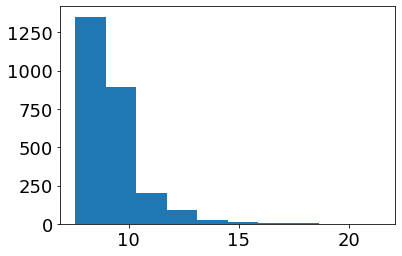

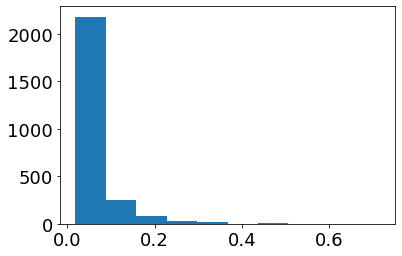

In [136]:
plt.hist(np.asarray(ages))
plt.show()

plt.hist(np.asarray(ages_err))
plt.show()

(10000000, 1000000000000)

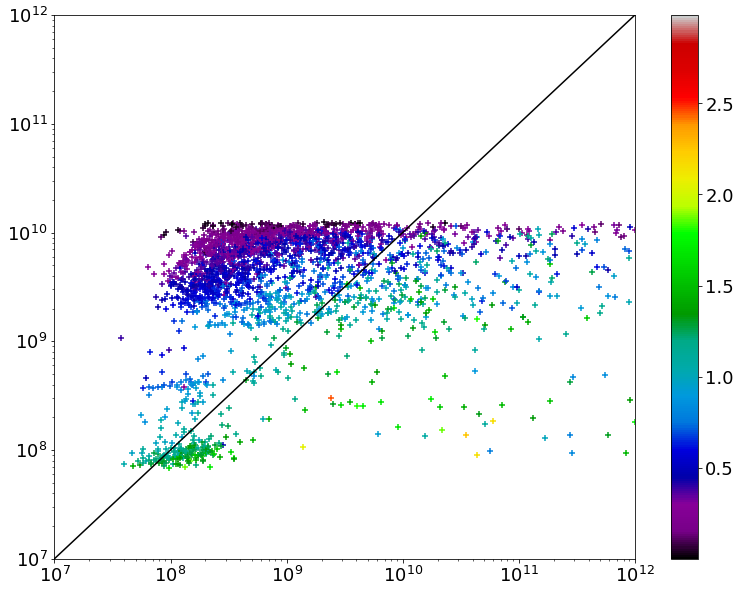

In [137]:
plt.figure(figsize=[13,10])
plt.scatter(10**np.asarray(ages)[r13_ind],10**pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
                marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
plt.ylim(10**7,10**12)
plt.xlim(10**7,10**12)